# USER MANUAL: How to use the simulator 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss
import cvxpy as cp
import sys

sys.path.append("../") 
import doe_utils

# TEST MAKE AMINO ACID WORLD SMALL 

AMINO_ACIDS = doe_utils.AMINO_ACIDS

# For simulation, create a random parent amino acid sequence to create SOLD libraries from

This is an example of a fully in silico path to test and understand the simulator. The functions in the simulator are written such that we can develop models from a given SOLD matrix.
Deep mutational scan at multiple locaitons also conform to the SOLD matrix abstraction 

## Pretend that a set of positions in the protein is mutated--create a sythesis SOLD matrix

In [2]:
length_of_protein = 100
num_mutated = 5
sold_mat_df, parent, mut_dict = doe_utils.create_synthetic_SOLD_matrix(num_mutated, length_of_protein, mut_probs = [0.25, 0.25, 0.25], parent_prob=0.25) #6 postions mutated, pprtein length is 100 
sold_mat_df.head() 
    

Parent protein: GVFPWVSHDCLDQWKINRVKWQFKVDKHAKNYHVKYSDLGFEKVWPEKGSELRMLGPHTHRRVKMLSTGIHQPQFYGFHIQRMYPDQVVKSYSFNPTAYL
Random mutaed positions [24 63 68 73 93]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0


# Plot the SOLD matrix 

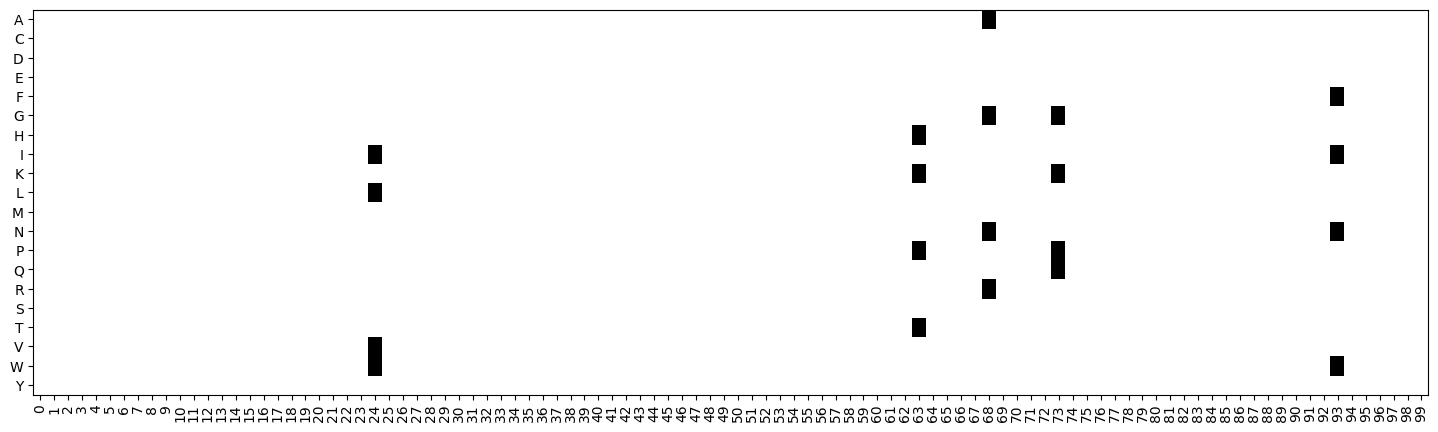

In [3]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


# Now let's try to draw mutated sequences from this matrix 

Above I have created a simple SOLD mat, but I want to make tools such that everything below will work with any experimentalist provided SOLD mat

In [4]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(10000)

In [5]:
seqs[0]

'IKNPF'

In [6]:
probs = S.compute_prob_n_mutations(num_mutated+1)

Text(0.5, 1.0, 'Sanity check: theory vs empirical counts \n of mutations observed in sampling using a SOLD mat')

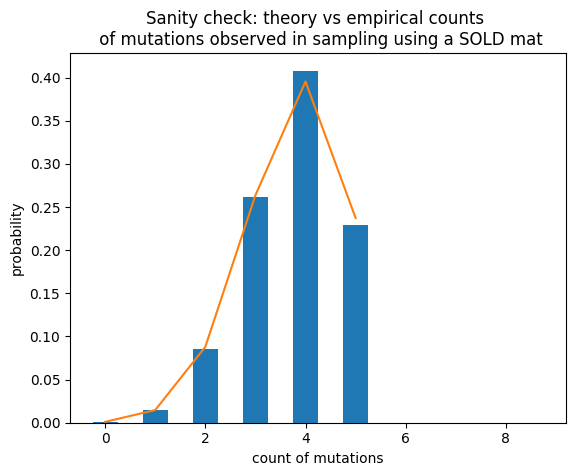

In [7]:
plt.hist(mutations, bins= np.array(range(10)) - 0.25, density = True, align = "mid", width = 0.5) 
plt.ylabel('probability')
plt.xlabel('count of mutations') 
plt.plot(probs)
plt.title("Sanity check: theory vs empirical counts \n of mutations observed in sampling using a SOLD mat")

# Now I need to provide weights to the independent and pairwise contributions

I create a mixture of pdfs to draw from, with a zero component (meaning not all independent and pairwise contributions have differential activity compared to parent, some have no effect, and one can control this effect size or model complexity in these simulations) 
Create a mixture of weigthts with random components and some sparse components 

In [8]:
I_params = {'rho':[0.49, 0.49], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 1, 'scale': 0.2}, {'loc': -1, 'scale': 0.2}]} 
P_params = {'rho':[0.49, 0.49], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 0.75, 'scale': 0.2}, {'loc': -0.75, 'scale': 0.2}]} 


Model_in_silico = doe_utils.create_in_silico_model(num_mutated, S.mutation_probs_variable_region_indexed, independent_params=I_params, pairwise_params=P_params)
Model_in_silico.plot_weights()

TypeError: _create_zero_mean_indepedent_feature_weights() missing 1 required positional argument: 'independent_feature_names'

In [ ]:
np.sum(Model_in_silico.pairwise_weights, axis = 0)

In [ ]:
Model_in_silico.independent_params

# Now compute respose for a bunch of seqs

Need to eocnde the sequeces into pairwise and independent features 


# ENCODE

In [ ]:
Encoder = doe_utils.sequence_encoder(num_mutated)
encodings = Encoder.encode_seqs(seqs) # this produces two lists --- the first 1 is the independent encodings, the second one is pairwise encodings 

In [ ]:
responses = Model_in_silico.model(encodings[0], encodings[1], masked= True) 

In [ ]:
_ = plt.hist(responses, bins = 25)
plt.title("in silico responses (indel activity)") 

# Now do sparse (elastic net) linear regression to learn back the weights 

In [ ]:
fit_model = doe_utils.fitting_model(S.mutation_probs_variable_region_indexed)
fitted_params, fit_responses = fit_model.fit(seqs, responses)
plt.figure() 
plt.scatter(Model_in_silico.ground_truth_params, fitted_params)
plt.xlabel("ground truth") 
plt.ylabel("fitted params") 



In [ ]:
import scipy 

plt.plot(scipy.linalg.svdvals(fit_model.features.T.dot(fit_model.features)))

plt.title('Null space problem, we have zero eigenvalues in feature matrix')
plt.yscale('log')

In [ ]:
plt.scatter(fitted_params[fit_model.pairwise_indices], Model_in_silico.pairwise_weights[Model_in_silico.pairwise_mask])

In [ ]:
A, B = doe_utils._create_zero_mean_pairwise_weights(fitted_params[fit_model.pairwise_indices], Model_in_silico.feature_names_pairwise, Model_in_silico.feature_names_independent)

In [ ]:
plt.scatter(A, Model_in_silico.pairwise_weights[Model_in_silico.pairwise_mask])

In [ ]:
c_mat = doe_utils._create_constraint_mat(Model_in_silico.feature_names_pairwise, Model_in_silico.feature_names_independent) 

In [ ]:
from sklearn.metrics import root_mean_squared_error
import re

def _create_zero_mean_pairwise_weights(pairwise_weights, pairwise_feature_names, independent_feature_names): 
    """
    Internal function to create legal pairwise weights
    J_{ia,jb} are the interaction epistatic terms 
    h_ia are the indepedent 
    I need to normalize such that any term in J_{ia,jb} cannot be explained away by h_ia ... 
    for exmaple, h_ia = sum_jb J_{ia, jb} for all the jb (poistion, amino acid) epistatic terms of ia (position i, amino acid a) 
    For every position i, pairing with all positions j, we need make sure  that the sum, sum_j J_ij = 0  
    We also need to do this for every amino acid pairs ab, for all positions, so sum_a J_ab = 0 irrespective of position 
    AND, for every feature ia for all it's partners jb we need to make sure sum_jb J_{ia,jb} = 0 

    This is because if for any a the term is not zero, that means there is abias for a ... but bias in a is captured in sum_i J_ia 
    But sum over a is the result for i, so we don't have to do this separetly 
    
    Args: 
        pairwise_weights: see in slico model class, this is the vecotor of pairwise weights 
        pairwise_feature_names: This are the names of the pariwise features 
        independent_feature_names: independnt features 
        
    """
    pairwise_vals = np.copy(pairwise_weights) 
    pairwise_vals_old = np.copy(pairwise_vals) 
    # I need to normalize such that \sum_j J_{ij} s_j = 0 so that we don't have an ambiguity in independent weight assignment h_i 
    TOLERANCE = 1e-12
    MAXITER = 100000
    num_iter = 0 
    delta = np.inf
    ## This is make sure \sum_i J_ij and \sum_j J_IJ  is zero
    loc_feature_names = np.asarray([a.split(':') for a in pairwise_feature_names]) 
    #loc_feature_names_2 = np.asarray([re.split(':' + "|" + '-', a) for a in pairwise_feature_names]) 

    independent_features_split = np.asarray([a.split('-') for a in independent_feature_names]) 
    pos = np.unique(independent_features_split[:,0])
    amino = np.unique(independent_features_split[:,1])
    while (delta > TOLERANCE) and (num_iter < MAXITER): 
        num_iter += 1 
        for i in independent_feature_names: #circle through every independent feature  
            pairwise_vals_old = np.copy(pairwise_vals) 
            inds1 = np.flatnonzero(loc_feature_names[:, 0] == i) 
            inds2 = np.flatnonzero(loc_feature_names[:, 1] == i) 
            inds = np.concatenate((inds1, inds2))
            pairwise_vals[inds] -= np.mean(pairwise_vals[inds]) 
            delta = root_mean_squared_error(pairwise_vals, pairwise_vals_old) 
            
    diff = np.zeros(len(independent_feature_names)) # find the individual weight diff (shift) needed to connrect the pairwise weights 
    for i, k in enumerate(independent_feature_names): #circle through every indepdnent feature  
        inds1 = np.flatnonzero(loc_feature_names[:, 0] == k)
        inds2 = np.flatnonzero(loc_feature_names[:, 1] == k)
        inds = np.concatenate((inds1, inds2)) 
        diff[i] = 0.5*np.mean(pairwise_weights[inds]) #because every term is counted twice, once for s_i and and again for s_j 
    return pairwise_vals, diff 

In [ ]:
loc_feature_names_2 = np.asarray([re.split(':' + "|" + '-', a) for a in Model_in_silico.feature_names_pairwise ]) 



In [ ]:
A, delta = _create_zero_mean_pairwise_weights(Model_in_silico.raw_pairwise_weights, Model_in_silico.feature_names_pairwise, Model_in_silico.feature_names_independent)

In [ ]:
B, delta2 = _create_zero_mean_pairwise_weights(Model_in_silico.raw_pairwise_weights, Model_in_silico.feature_names_pairwise, Model_in_silico.feature_names_independent)

In [ ]:
plt.plot(delta)
plt.plot(delta2, '--')

In [ ]:

def _create_constraint_mat(pairwise_feature_names, independent_feature_names): 
    """
    Internal function to create constrained mat

    There are two kinds of constraints 
    sum_i J_ij = 0 
    sum_j J_ij = 0 for every feature i, j 

    I also need to create constraint mat for sum over every position of all features is zero 
    so sum_a h_ia where now h_ia is the weight for ith position and amino acid a 
    This implies h'_j  := sum_i J_ij also must be zero when we sum this over the the position p 
    where j = (p,a), the position and amino acid together make the feature
    Args: 
        pairwise_feature_names: This are the names of the pariwsie features 
        inpdendent_feature_names: names of independent features 
    """

    split_pair_feature_names = np.asarray([a.split(':') for a in pairwise_feature_names]) 
    L = len(pairwise_feature_names)
    constrained_mat_J = [] 
    for i in independent_feature_names: #circle through every indepednent feature 
        local_vec = np.zeros(L) 
        inds1 = np.flatnonzero(split_pair_feature_names[:, 0] == i) 
        inds2 = np.flatnonzero(split_pair_feature_names[:, 1] == i) 
        inds = np.concatenate((inds1, inds2)) 
        local_vec[inds] = 1
        constrained_mat_J.append(local_vec) 

    pos_feat_independent = np.asarray([a.split('-') for a in independent_feature_names])
    K = len(independent_feature_names) 
    pos = np.unique(pos_feat_independent[:,0])
    constrained_mat_H = [] 
    
    for i in pos:
        local_vec = np.zeros(K)
        inds = np.flatnonzero(pos_feat_independent[:,0] == i) 
        local_vec[inds] = 1
        constrained_mat_H.append(local_vec) 


    constrained_mat_H = np.asarray(constrained_mat_H) 
    constrained_mat_J = np.asarray(constrained_mat_J)

    # Now I need to concatenate all of this -- and add zeros for the h features and J features 
    temp = np.zeros((len(constrained_mat_J), K))
    c_mat_1 = np.hstack((temp, constrained_mat_J))

    num_pairwise = len(pairwise_feature_names)
    temp = np.zeros((len(constrained_mat_H),L))
    c_mat_2 = np.hstack((constrained_mat_H, temp))
    cmat = np.vstack((c_mat_1, c_mat_2)) 
    return cmat

In [ ]:
def _create_zero_mean_indepedent_feature_weights(independent_weights, independent_feature_names): 
    """
    Get rid of null space by making sure that the independent features at every position do not have bias of position alone 
    which should be fitted separately 
    Args: 
        independent_weights 
        independent_feature_names 
    """
    independent_vals = np.copy(independent_weights) 
    pos_feat_independent = np.asarray([a.split('-') for a in independent_feature_names])
    pos = np.unique(pos_feat_independent[:,0]) 
    for i in pos:
        inds = np.flatnonzero(pos_feat_independent[:, 0] == i) 
        independent_vals[inds] -= np.mean(independent_vals[inds]) 

    return independent_vals

In [ ]:
_create_zero_mean_indepedent_feature_weights(Model_in_silico.independent_weights, Model_in_silico.feature_names_independent)